# Week 4 - Word Embeddings

This week, we build on last week's topic modeling techniques by taking a text corpus we have developed, specifying an underlying number of dimensions, and training a model with a neural network auto-encoder (one of Google's word2vec  algorithms) that best describes corpus words in their local linguistic contexts, and exploring their locations in the resulting space to learn about the discursive culture that produced them. Documents here are represented as densely indexed locations in dimensions, rather than sparse mixtures of topics (as in LDA topic modeling), so that distances between those documents (and words) are consistently superior, though they require the full vector of dimension loadings (rather than just a few selected topic loadings) to describe. We will explore these spaces to understand complex, semantic relationships between words, index documents with descriptive words, identify the likelihood that a given document would have been produced by a given vector model, and explore how semantic categories can help us understand the cultures that produced them.

For this notebook we will be using the following packages

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import nltk #For stop words and stemmers
import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#gensim uses a couple of deprecated features
#we can't do anything about them so lets ignore them 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

c:\users\andrew\appdata\local\programs\python\python36\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Getting our corpora

Instead of downloading our corpora, we have download them in advance; a subset of the [senate press releases](https://github.com/lintool/GrimmerSenatePressReleases) are in `grimmerPressReleases`. We will load them into a DataFrame, using a function from a couple weeks ago `loadTextDirectory`:

In [2]:
kennedyDF = lucem_illud.loadTextDirectory('../data/grimmerPressReleases/Kennedy/')
kennedyDF[:5]

,text
01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...
01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...
01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...
01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...
01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...


This gets us one Senator's data, but with no metadata, we can add a category column with a simple command:

In [3]:
kennedyDF['category'] = 'Kennedy'
kennedyDF[:5]

,text,category
01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


We also will be wanting to load all the senators so we will need to loop over all the directories

In [4]:
dataDir = '../data/grimmerPressReleases'

senReleasesDF = pandas.DataFrame()

for senatorDir in (file for file in os.scandir(dataDir) if not file.name.startswith('.') and file.is_dir()):
    senDF = lucem_illud.loadTextDirectory(senatorDir.path)
    senDF['category'] = senatorDir.name
    senReleasesDF = senReleasesDF.append(senDF, ignore_index = False)

senReleasesDF[:5]

,text,category
01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


We also want to remove stop words and stem. Tokenizing requires two steps. Word2Vec needs to retain the sentence structure so as to capture a "continuous bag of words (CBOW)" and all of the skip-grams within a word window. The algorithm tries to preserve the distances induced by one of these two local structures. This is very different from clustering and LDA topic modeling which extract unordered words alone. As such, tokenizing is slightly more involved, but we can still use `lucem_illud`.

In [5]:
#Apply our functions, notice each row is a list of lists now
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: 
                                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: 
                                                                           [lucem_illud.normalizeTokens(s, 
                                                                                           stopwordLst = lucem_illud.stop_words_basic, 
                                                                                           stemmer = None) 
                                                                            for s in x])

senReleasesDF[:5]

,text,category,tokenized_sents,normalized_sents
01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, cont..."
01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, cont..."
01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, wash..."
01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, wash..."
01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, cont..."


# Word2Vec

We will be using the gensim implementation of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec).

To load our data, we give all the sentences to the trainer. We just need to add the words as a list of sentences:

In [6]:
senReleasesW2V = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sum())

Inside the word2vec object, the words each have a vector. To access the vector directly, use the square braces (`__getitem__`) method:

In [7]:
print("A {} dimesional vector:".format(senReleasesW2V['president'].shape[0]))
senReleasesW2V['president']

A 100 dimesional vector:


array([ 2.4466183 , -1.3200643 ,  1.1754942 , -2.5440223 ,  0.6602763 ,
       -1.9527084 ,  1.0255735 , -0.6697826 ,  0.21679494,  0.29884762,
        0.54188555, -2.2384784 , -1.4590354 ,  1.3806713 ,  2.1912825 ,
        0.02015093,  2.3412569 ,  2.7323546 , -3.0405252 ,  0.86049366,
        0.42992207,  0.8393139 , -2.932011  ,  1.348096  ,  0.2687939 ,
       -1.5054699 ,  3.707573  ,  2.5192487 , -0.05631046,  0.2032572 ,
       -0.78920084, -1.4912838 ,  1.2078873 , -0.51152945, -2.572017  ,
       -1.6824322 ,  0.4133992 ,  1.4056545 ,  1.4908612 ,  1.438988  ,
       -1.2954099 ,  0.7110585 ,  1.4115838 ,  1.4552451 ,  0.11420558,
        0.4306166 ,  1.6057571 ,  0.02949693,  2.7673717 , -1.31807   ,
        0.7641875 , -3.2072191 ,  0.8644992 ,  0.6764996 , -0.4559398 ,
       -1.7001077 , -0.45467484,  0.29354137, -1.8602215 ,  1.6834128 ,
        1.6810448 , -1.4731003 ,  0.2571231 ,  1.4767077 , -0.632983  ,
       -1.2874956 ,  2.3953974 , -0.6940001 ,  0.38843465,  0.38

If you want the full matrix, `syn0` stores all the vectors:

In [8]:
senReleasesW2V.wv.syn0

array([[-1.07032883e+00,  6.62285686e-01, -2.79125750e-01, ...,
        -2.97281355e-01,  7.60464668e-01, -2.20023179e+00],
       [ 2.47933960e+00,  1.92246544e+00, -1.26368856e+00, ...,
         2.32000399e+00, -3.73335928e-01, -2.41652465e+00],
       [-2.71740127e+00, -9.33073699e-01,  5.03785074e-01, ...,
         4.19152886e-01, -7.68157482e-01, -1.65019488e+00],
       ...,
       [-2.49753278e-02,  4.84306412e-03,  9.56536010e-02, ...,
        -6.52064607e-02,  7.26762488e-02, -6.77191019e-02],
       [-3.97333130e-02, -6.20692894e-02,  6.09782971e-02, ...,
        -4.71467748e-02,  6.48500323e-02, -2.60078278e-03],
       [-2.69666053e-02, -1.48888016e-02,  1.19315259e-01, ...,
        -1.20066084e-01,  1.17588617e-01, -1.29363403e-01]], dtype=float32)

Then, `index2word` lets you translate from the matrix to words

In [9]:
senReleasesW2V.wv.index2word[10]

'american'

Now we can look at a few things that come from the word vectors. The first is to find similar vectors (cosine similarity):

In [10]:
senReleasesW2V.most_similar('president')

[('administration', 0.7734957337379456),
 ('presidents', 0.7458186149597168),
 ('administrations', 0.6756553053855896),
 ('george', 0.609849214553833),
 ('cheney', 0.6016781330108643),
 ('responds', 0.5321186780929565),
 ('quoting', 0.5302079916000366),
 ('rollback', 0.5283740162849426),
 ('ronald', 0.5257267355918884),
 ('republican', 0.4976758062839508)]

In [11]:
senReleasesW2V.most_similar('war')

[('wars', 0.6643564105033875),
 ('afghanistan', 0.649229884147644),
 ('disobedience', 0.6408018469810486),
 ('quagmire', 0.622207760810852),
 ('unresisted', 0.6127890348434448),
 ('battle', 0.6111575961112976),
 ('chaos', 0.5932959914207458),
 ('descending', 0.5921586751937866),
 ('insurgency', 0.5882351398468018),
 ('militarily', 0.5866488218307495)]

Or we can get this directly (calculated slightly differently):

In [17]:
def cos_difference(embedding,word1,word2):
    return sklearn.metrics.pairwise.cosine_similarity(embedding[word1].reshape(1,-1),embedding[word2].reshape(1,-1))

In [13]:
cos_difference(senReleasesW2V, 'war', 'unwinnable')

array([[0.49126574]], dtype=float32)

We can also find which word least matches the others within a word set (cosine similarity):

In [14]:
senReleasesW2V.doesnt_match(['administration', 'administrations', 'presidents', 'president', 'washington'])

'washington'

Find which word best matches the result of a semantic *equation* (here, we seek the words whose vectors best fit the missing entry from the equation: **X + Y - Z = _**.

In [15]:
senReleasesW2V.most_similar(positive=['clinton', 'republican'], negative = ['democrat'])

[('vetoed', 0.7051807045936584),
 ('bush', 0.6912012696266174),
 ('veto', 0.6900606155395508),
 ('blocked', 0.6640416383743286),
 ('vetoes', 0.6530345678329468),
 ('bushs', 0.6495181322097778),
 ('proposing', 0.6299116611480713),
 ('signature', 0.6281898021697998),
 ('signed', 0.6154439449310303),
 ('nail', 0.5918359756469727)]

Here we see that **Clinton + Republican - Democrat = Bush**. In other words, in this dataset and period, **Clinton** was to **Democrat** as **Bush** was to **Republican**. Whoah!

 But how do we argue that these are stable distances or associations?

## Establishing Credible or Confidence Intervals

### Boostrapping approach

We propose well-established bootstrapping and subsampling methods to nonparametrically demonstrate the stability and significance of word associations within our embedding model. These allow us to establish conservative confidence intervals to both (a) distances between words in a model and (b) projections of words onto an induced dimension (e.g., man-woman). If we assume that the texts (e.g., newspapers, books) underlying our word embedding model are observations drawn from an independent and identically distributed (i.i.d.) population of cultural observations, then bootstrapping allows us to estimate the variance of word distances and projections by measuring those properties through sampling the empirical distribution of texts with replacement (Efron and Tibshirani 1994; Efron 2003). Operationally, if we wanted to bootstrap a 90% confidence interval of a word-word distance or word-dimension projection, we would sample a corpus the same size as the original corpus, but with replacement, 20 times, estimate word embedding models on each sample. Then we take the 2nd order (2nd smallest) statistic $s_{(2)}$--either distance or projection--as our confidence interval’s lower bound, and 19th order statistic $s_{(19)}$ as its upper bound. The distance between $s_{(2)}$ and $s_{(19)}$ across 20 bootstrap samples span the 5th to the 95th percentiles of the statistic’s variance, bounding the 90th confidence interval. A 95% confidence interval would span $s_{(2)}$ and $s_{(39)}$ in word embedding distances or projections estimated on 40 bootstrap samples of a corpus, tracing the 2.5th to 97.5th percentiles. 

In [16]:
estimatesB=[]
for x in range(20):
    senReleasesW2VB = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sample(frac=1.0, replace=True).sum())
    try:
        estimatesB.append(cos_difference(senReleasesW2VB, 'war', 'unwinnable')[0,0])
    except KeyError:
        #Missing one of the words from the vocab
        pass
                                                      
estimatesB.sort()         
estimatesB

[0.26140133,
 0.32364127,
 0.3343975,
 0.3819371,
 0.3977269,
 0.3982087,
 0.41853404,
 0.45023268,
 0.46786943,
 0.48427168,
 0.5230077,
 0.55024207,
 0.61758876,
 0.714847]

In [17]:
print("The 90% confidence interval for the cosine distance between war and unwinnable is:\n",estimatesB[1], estimatesB[-2])

The 90% confidence interval for the cosine distance between war and unwinnable is:
 0.32364127 0.61758876


### Subsampling approach

If the corpus is large, then we may take a subsampling approach, which randomly partitions the corpus into non-overlapping samples, then estimates the word-embedding models on these subsets and calculates confidence intervals as a function of the empirical distribution of distance or projection statistics and number of texts in the subsample (Politis and Romano 1997). Subsampling requires the same i.i.d. assumption as the bootrap (Politis and Romano 1992; Politis and Romano 1994). For 90% confidence intervals, we randomly partition the corpus into 20 subcorpora, then calculate $B^k=\sqrt{\tau_k}\left(s^k-\bar{s}\right)$ for each $k$th sample, where $k$ is the number of texts and $s^k$ is the embedding distance or projection for the $k$th sample, and $\bar{s}$ is the average statistic for all samples. The 90% confidence interval spans the 5th to 95th percentile variances, inscribed by $\bar{s}-\frac{B_{(19)}^k}{\sqrt{\tau}}$ and $\bar{s}-\frac{B_{(2)}^k}{\sqrt{\tau}}$, where $\tau$ the number of texts in the total corpus and $s$ is the average statistic across all subsamples. As with bootrapping, a 95% confidence interval would require 40 subsamples; a 99% confidence would require 200 (.5th to 99.5th percentiles).

In [20]:
senReleasesDF[sample_indices == i]

NameError: name 'sample_indices' is not defined

In [21]:
n_samples = 10
sample_indices = np.random.randint(0,n_samples,(len(senReleasesDF),))

s_k =np.array([])
tau_k=np.array([])

for i in range(n_samples):
    sample_w2v = gensim.models.word2vec.Word2Vec(senReleasesDF[sample_indices == i]['normalized_sents'].sum())
    try:
        #Need to use words present in most samples
        s_k = np.append(s_k, cos_difference(sample_w2v, 'war', 'responsibility')[0,0])
    except KeyError:
        pass
    else:
        tau_k = np.append(tau_k, len(senReleasesDF[sample_indices == i]))

print(s_k)
print(tau_k)

tau = tau_k.sum()
s = s_k.mean()
B_k = np.sqrt(tau_k) * s_k-s_k.mean()

[0.97870177 0.99572694 0.99562448 0.95073771 0.99353606 0.95295137
 0.98833168 0.99419063 0.93485093 0.95254779]
[383. 390. 380. 402. 367. 395. 388. 397. 419. 383.]


In [22]:
print("The 90% confidence interval for the cosine distance between war and responsibility is:\n",s-B_k[-2]/np.sqrt(tau), s-B_k[1]/np.sqrt(tau))

The 90% confidence interval for the cosine distance between war and responsibility is:
 0.683040987028134 0.6745887887091121


We can also save the vectors for later use:

In [23]:
senReleasesW2V.save("senpressreleasesWORD2Vec.mm")
#Load with senReleasesW2V = gensim.models.word2vec.Word2Vec.load('senpressreleasesWORD2Vec.mm')

## Visualize

We can also use dimension reduction to visulize the vectors. We will start by selecting a subset we want to plot. Let's look at the top words from the set:

In [24]:
numWords = 150
targetWords = senReleasesW2V.wv.index2word[:numWords]

We can then extract their vectors and create our own smaller matrix that preserved the distances from the original:

In [25]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(senReleasesW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-1.0703288 ,  0.6622857 , -0.27912575, ..., -0.29728135,
         0.76046467, -2.2002318 ],
       [ 2.4793396 ,  1.9224654 , -1.2636886 , ...,  2.320004  ,
        -0.37333593, -2.4165246 ],
       [-2.7174013 , -0.9330737 ,  0.5037851 , ...,  0.4191529 ,
        -0.7681575 , -1.6501949 ],
       ...,
       [ 0.40475163,  1.0131457 , -0.12984873, ..., -0.36399004,
         0.22120844, -1.326513  ],
       [ 0.16963232, -0.44604835, -0.07262771, ..., -0.5104725 ,
         0.886871  ,  0.41155785],
       [ 0.37996483, -0.31794795,  1.2117211 , ...,  1.6058269 ,
        -0.92251664, -0.6591274 ]], dtype=float32)

Then we can use PCA to reduce the dimesions (e.g., to 50), and [T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) to project them down to the two we will visualize. We note that this is nondeterministic process, and so you can repeat and achieve alternative projectsions/visualizations of the words:

In [26]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(reducedPCA_data)

We now can plot the points

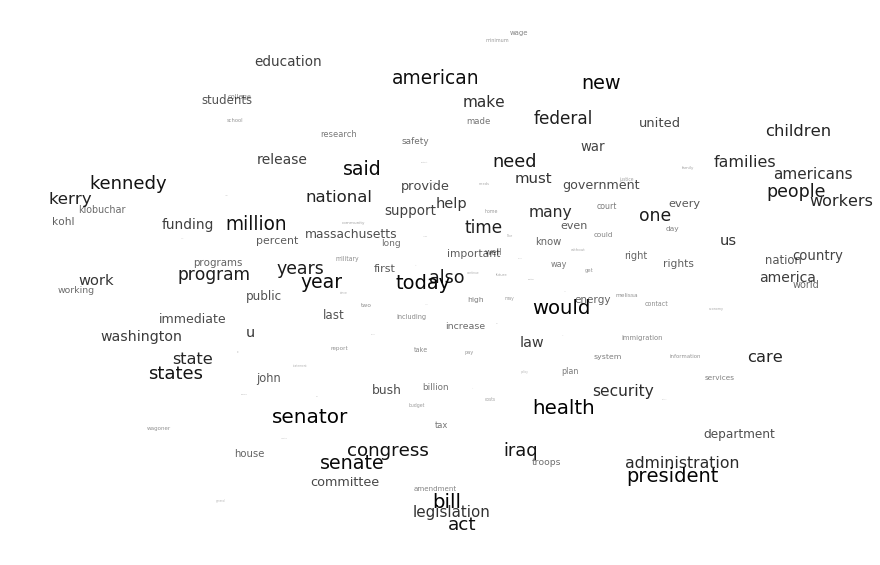

In [27]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, 
                (tsneWords[:, 0][i],tsneWords[:, 1][i]), 
                size =  20 * (numWords - i) / numWords, 
                alpha = .8 * (numWords - i) / numWords + .2)
plt.xticks(())
plt.yticks(())
plt.show()

My visualization above puts ``iraq`` next to ``time`` and ``bill`` near ``help``. <img src='../data/examplewordcloud.svg'>

What if a new senator come along with whose names starts with K? Could we analyse their releases too without rerunning the entire embedding? Lets try with Cardin in `../data/grimmerPressReleases_extra/Cardin`. First we need to load and proccess the releases:

In [28]:
cardinDF = lucem_illud.loadTextDirectory('../data/grimmerPressReleases_extra/Cardin')
cardinDF['category'] = 'Cardin'

cardinDF['tokenized_sents'] = cardinDF['text'].apply(lambda x: 
                                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
cardinDF['normalized_sents'] = cardinDF['tokenized_sents'].apply(lambda x: 
                                                                           [lucem_illud.normalizeTokens(s, 
                                                                                           stopwordLst = lucem_illud.stop_words_basic, 
                                                                                           stemmer = None) 
                                                                            for s in x])

cardinDF[:10]

,text,category,tokenized_sents,normalized_sents
01Aug2007Cardin156.txt,...,Cardin,"[[CARDIN, MIKULSKI, PRAISES, PASSAGE, OF, STRO...","[[cardin, mikulski, praises, passage, strong, ..."
01Feb2007Cardin297.txt,...,Cardin,"[[CARDIN, VOTES, TO, INCREASE, MINIMUM, WAGE, ...","[[cardin, votes, increase, minimum, wage, pay,..."
01Feb2007Cardin298.txt,...,Cardin,"[[S, 453, SEN, CARDIN, CO, SPONSORS, BILL, TO,...","[[sen, cardin, co, sponsors, bill, protect, vo..."
01Feb2007Cardin299.txt,...,Cardin,"[[S, 450, CARDIN, INTRODUCES, BILL, TO, ELIMIN...","[[cardin, introduces, bill, eliminate, arbitra..."
01Jun2007Cardin199.txt,...,Cardin,"[[CARDIN, MIKULSKI, ANNOUNCE, 7, 3, MILLION, F...","[[cardin, mikulski, announce, million, hagerst..."
01Jun2007Cardin200.txt,...,Cardin,"[[CARDIN, MIKULSKI, ANNOUNCE, 4, 6, MILLION, F...","[[cardin, mikulski, announce, million, salisbu..."
01Mar2007Cardin279.txt,...,Cardin,"[[SEN, CARDIN, FIGHTS, TO, IMPROVE, SECURITY, ...","[[sen, cardin, fights, improve, security, amer..."
01Mar2007Cardin280.txt,...,Cardin,"[[CARDIN, MIKULSKI, ANNOUNCE, 35, 000, FOR, WE...","[[cardin, mikulski, announce, western, marylan..."
01May2007Cardin228.txt,...,Cardin,"[[STATEMENT, BY, U, S, SENATOR, BENJAMIN, L, C...","[[statement, u, senator, benjamin, l, cardin, ..."
01May2007Cardin229.txt,...,Cardin,"[[CARDIN, TELLS, THE, AG, COMMITTEE, THAT, THE...","[[cardin, tells, ag, committee, farm, bill, co..."


We can now merge Cardin's releases with the rest. This can update all the weights in *w2v* model, so be careful.

In [29]:
#This is using a newer API so we have to tell it a little bit more for it to work right
senReleasesW2V.build_vocab(cardinDF['normalized_sents'].sum(), update=True)
senReleasesW2V.train(cardinDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=senReleasesW2V.iter)
senReleasesW2V.save("senpressreleasesWORD2Vec_new.mm")

As the model is updated by this, we need to load our old copy to do a comparison.

In [30]:
senReleasesW2V_old = gensim.models.word2vec.Word2Vec.load('senpressreleasesWORD2Vec.mm')

In [31]:
print("A {} dimesional vector:".format(senReleasesW2V['president'].shape[0]))
senReleasesW2V['president'][:10]

A 100 dimesional vector:


array([ 2.5689578 , -1.1457541 ,  1.2025913 , -2.7483582 ,  0.75419635,
       -2.6164918 ,  1.4967729 , -0.73965645,  0.4625182 ,  0.5365597 ],
      dtype=float32)

In [32]:
print("A {} dimesional vector:".format(senReleasesW2V_old['president'].shape[0]))
senReleasesW2V_old['president'][:10]

A 100 dimesional vector:


array([ 2.4466183 , -1.3200643 ,  1.1754942 , -2.5440223 ,  0.6602763 ,
       -1.9527084 ,  1.0255735 , -0.6697826 ,  0.21679494,  0.29884762],
      dtype=float32)

In [33]:
(senReleasesW2V_old['president'] - senReleasesW2V['president'])[:10]

array([-0.12233949, -0.1743102 , -0.02709711,  0.20433593, -0.09392005,
        0.66378343, -0.4711994 ,  0.06987387, -0.24572325, -0.23771209],
      dtype=float32)

As you can see the vector for 'president' has changed a little bit and the word cloud should also be a bit different too

In [34]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(reducedPCA_data)

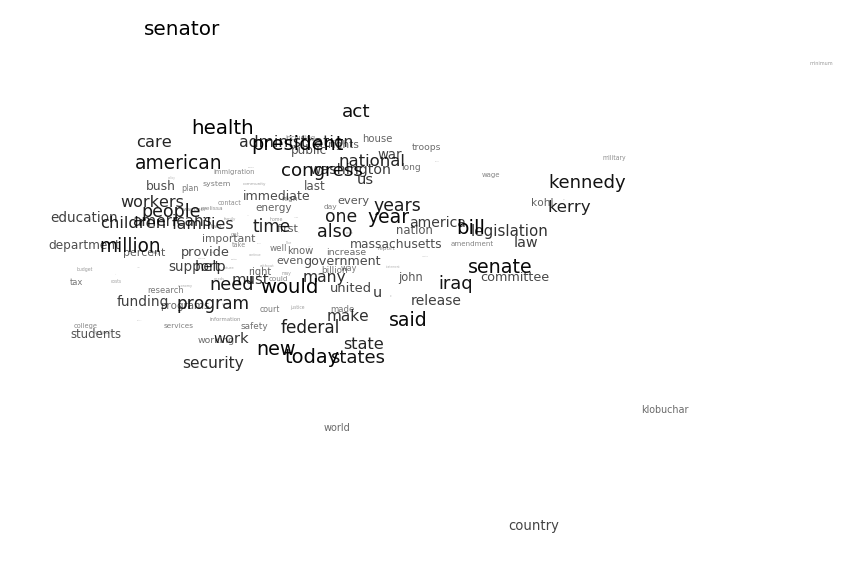

In [35]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, 
                (tsneWords[:, 0][i],tsneWords[:, 1][i]), 
                size =  20 * (numWords - i) / numWords, 
                alpha = .8 * (numWords - i) / numWords + .2)
plt.xticks(())
plt.yticks(())
plt.show()

Another thing to consider in training is how we know that our parameters for the model are correct. We can do this by looking at the training loss of the model. Let's tart by training a new model, but this time we will expose most of the options and train it one epoch at a time. Look [here](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) for more detail: 

In [36]:
senReleasesW2V_loss = gensim.models.word2vec.Word2Vec(size = 100, #dimensions
                                                      alpha=0.025,
                                                      window=5,
                                                      min_count=5,
                                                      hs=0,  #hierarchical softmax toggle
                                                      compute_loss = True,
                                                     )
senReleasesW2V_loss.build_vocab(senReleasesDF['normalized_sents'].sum())
senReleasesW2V_loss.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=1, #This the running_training_loss is a total so we have to do 1 epoch at a time
                    )
#Using a list so we can capture every epoch
losses = [senReleasesW2V_loss.running_training_loss]
losses[0]

1996287.0

Now we have the training loss and can optimize training to minimize it.

In [37]:
for i in range(19):
    senReleasesW2V_loss.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=1,
                             )
    losses.append(senReleasesW2V_loss.running_training_loss)
    print("Done epoch {}".format(i + 2), end = '\r')

Lets plot the loss vs epoch

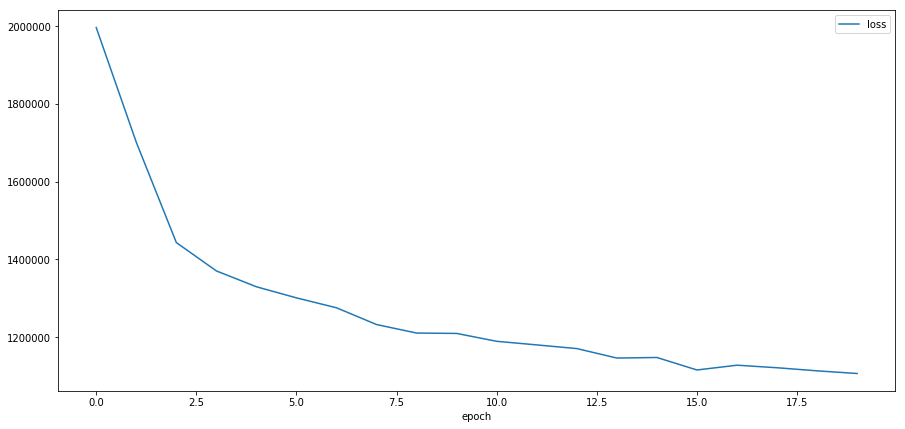

In [38]:
lossesDF = pandas.DataFrame({'loss' : losses, 'epoch' : range(len(losses))})
lossesDF.plot(y = 'loss', x = 'epoch', logy=False, figsize=(15, 7))
plt.show()

You should see that the loss is almost monotonic, but that the rate decreases as epoch increases. Since we are testing on our training data monotonicity is a common result and we must try to avoid over fitting. A simple way to do this is to stop training when there is significant change in the rate of decrease. In this run, that looks to be approximately 8 or 9. If we were to do another analysis, we might use an `iter=9` instead of the default 5.

Even more culturally interesting is how many dimensions are required to achieve an optimal embedding. The use of words in complex ways and contradictory contexts will require more dimensions to represent them with integrity. For example, if one word, $w_a$, is "nearby" $w_b$, but $w_b$ is not near the other words beside $w_a$, then a new dimension will be required for the two words to be uniquely together. 

In [39]:
losses_dims=[]

for d in [50,100,150,200,250,300,350,400,450,500, 550, 600, 650, 700, 750]:
    senReleasesW2V_loss_dims = gensim.models.word2vec.Word2Vec(size = d, #dimensions
                                                      alpha=0.025,
                                                      window=5,
                                                      min_count=5,
                                                      hs=0,  #hierarchical softmax toggle
                                                      compute_loss = True,
                                                     )
    senReleasesW2V_loss_dims.build_vocab(senReleasesDF['normalized_sents'].sum())
    senReleasesW2V_loss_dims.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=7, #This the running_training_loss is a total so we have to do 1 epoch at a time
                    )
    senReleasesW2V_loss_dims.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=1, #This the running_training_loss is a total so we have to do 1 epoch at a time
                    )
    
    losses_dims.append(senReleasesW2V_loss_dims.running_training_loss/(10+d*10))

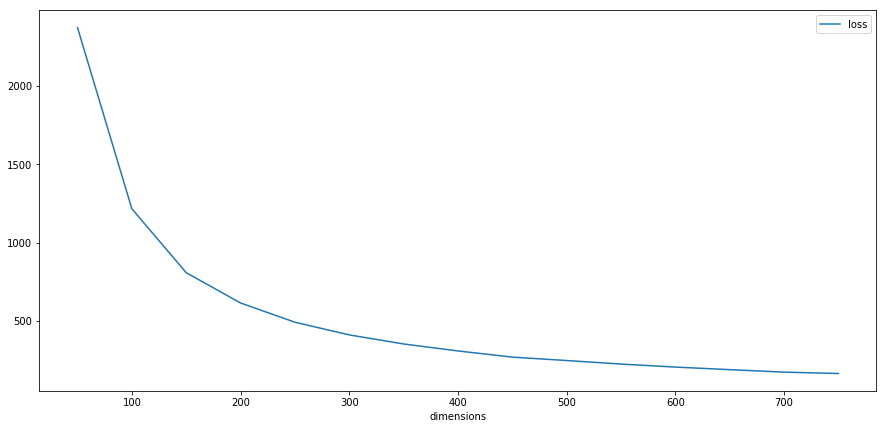

In [40]:
losses_dimsDF = pandas.DataFrame({'loss' : losses_dims, 'dimensions' : [50,100,150,200,250,300,350,400,450,500,550,600,650,700,750]})
losses_dimsDF.plot(y = 'loss', x = 'dimensions', logy=False, figsize=(15, 7))
plt.show()

This is a work in progress for Gensim, but its clear that most of the word distance variation is captured by 300 dimensions.

# Chinese examples

In [41]:
model=gensim.models.Word2Vec.load('../data/1992embeddings_hs_new3.sg')

## analogy

King+man-Queen? A few examples based on a corpus of Chinese news. 

First, location analogy: **province -> capital**

In [42]:
mm = model.most_similar(positive=[u'长沙',u'陕西'], negative=[u'湖南']) # Changsha + Shaanxi - Hunan
for m in mm:
    print(m[0],m[1])
    print("Xi'an")
    break

西安 0.36609965562820435
Xi'an


In [43]:
mm = model.most_similar(positive=[u'广州',u'湖北'], negative=[u'广东']) # Guangzhou + Hubei - Guangdong
for m in mm:
    print(m[0],m[1])
    print("Wuhan")
    break

武汉 0.3676999807357788
Wuhan


Second, location analogy: **country -> capital**

In [44]:
mm = model.most_similar(positive=[u'东京',u'美国'], negative=[u'日本']) # Tokyo + US - Japan
for m in mm:
    print(m[0],m[1])
    print("(Washington DC)")
    break

华盛顿 0.508813738822937
(Washington DC)


## similar words

In [45]:
word = u'社会主义'  #socialism
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

the most similar words to 社会主义 is: 
特色
市场经济
理论
建设
改革开放
马克思主义
党
经济体制
基本路线
现代化



In [46]:
word = u'玉米'  # corn
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

the most similar words to 玉米 is: 
小麦
水稻
作物
棉花
新品种
杂交
大豆
增产
栽培
农作物



## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that build a word2vec model with your corpus. Interrogate word relationships in the resulting space, including estimating 90% confidence intervals for specific word cosine distances of interest. Plot a subset of your words. What do these word relationships reveal about the *social* and *cultural game* underlying your corpus? What was surprising--what violated your prior understanding of the corpus? What was expected--what confirmed your knowledge about this domain?

In [3]:
#import dataset of letters to shareholders
df = pandas.read_pickle('C:\\Users\\Andrew\\content-analysis-2018\\content-analysis-2018\\2-Corpus-Linguistics\\pandasDF.pkl')
df.head()

,company,text,year
0,3M Letter,dear shareholder:\n\nthanks to the hard work o...,2000
1,Alcoa Letter,luluâ\nmumÂ» nl am.â\n\n \n\n \n\n1â0 ai...,2000
2,American Express Letter,"cardmembers, a reflection of our successful ef...",2000
3,AT&T Letter,the transformation of at&t\n\nthree years ago ...,2000
4,Boeing Letter,here is our plan for growing the boeing compan...,2000


In [4]:
#remove stop words while preserving sentence structure
df['tokenized_sents'] = df['text'].apply(lambda x: 
                                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
df['normalized_sents'] = df['tokenized_sents'].apply(lambda x: 
                                                                           [lucem_illud.normalizeTokens(s, 
                                                                                           stopwordLst = lucem_illud.stop_words_basic, 
                                                                                           stemmer = None) 
                                                                            for s in x])

df[:5]

,company,text,year,tokenized_sents,normalized_sents
0,3M Letter,dear shareholder:\n\nthanks to the hard work o...,2000,"[[dear, shareholder, :, thanks, to, the, hard,...","[[dear, shareholder, thanks, hard, work, oftho..."
1,Alcoa Letter,luluâ\nmumÂ» nl am.â\n\n \n\n \n\n1â0 ai...,2000,"[[luluâ, mumÂ, », nl, am.â, 1â0, aicoa, ...","[[mumâ, nl, aicoa, sharehoiders, yea], [tnlury..."
2,American Express Letter,"cardmembers, a reflection of our successful ef...",2000,"[[cardmembers, ,, a, reflection, of, our, succ...","[[cardmembers, reflection, successful, efforts..."
3,AT&T Letter,the transformation of at&t\n\nthree years ago ...,2000,"[[the, transformation, of, at, &, t, three, ye...","[[transformation, three, years, ago, clear, te..."
4,Boeing Letter,here is our plan for growing the boeing compan...,2000,"[[here, is, our, plan, for, growing, the, boei...","[[plan, growing, boeing, covers, three, period..."


In [5]:
#import data into trainer
lettersW2V = gensim.models.word2vec.Word2Vec(df['normalized_sents'].sum())

In [9]:
lettersW2V.most_similar('education')

[('skills', 0.9901850819587708),
 ('healthcare', 0.9885253310203552),
 ('teams', 0.9882533550262451),
 ('resources', 0.9880890846252441),
 ('expertise', 0.987407922744751),
 ('solve', 0.9848062992095947),
 ('tools', 0.9819425940513611),
 ('settings', 0.9815236330032349),
 ('deep', 0.9806320667266846),
 ('address', 0.9800875186920166)]

In [10]:
lettersW2V.most_similar('dividend')

[('dividends', 0.9825845956802368),
 ('quarterly', 0.9823449850082397),
 ('returned', 0.9792618751525879),
 ('buybacks', 0.9778077602386475),
 ('month', 0.9743553400039673),
 ('ended', 0.9738460183143616),
 ('stock', 0.9729856252670288),
 ('quarter', 0.9718713760375977),
 ('eps', 0.9711862802505493),
 ('record', 0.9708837270736694)]

In [11]:
lettersW2V.most_similar('customer')

[('service', 0.9617198705673218),
 ('quality', 0.9382018446922302),
 ('providing', 0.9351354837417603),
 ('relationships', 0.9316508769989014),
 ('improve', 0.9278054237365723),
 ('range', 0.9271877408027649),
 ('platforms', 0.9217761754989624),
 ('networks', 0.9209244847297668),
 ('analytics', 0.9207053780555725),
 ('platform', 0.9199063777923584)]

In [14]:
lettersW2V.most_similar(positive=['employee', 'help'], negative = ['dividend'])

[('communities', 0.9582213759422302),
 ('needs', 0.9523147344589233),
 ('ways', 0.9448292255401611),
 ('lives', 0.9360747337341309),
 ('make', 0.9344277381896973),
 ('need', 0.9329724311828613),
 ('helping', 0.9325476288795471),
 ('serve', 0.9287484884262085),
 ('live', 0.9277434349060059),
 ('better', 0.9264242649078369)]

In [15]:
lettersW2V.most_similar(positive=['employee', 'dividend'], negative = ['help'])

[('consecutive', 0.9649271965026855),
 ('ended', 0.9618484973907471),
 ('quarter', 0.9616119861602783),
 ('quarterly', 0.955471932888031),
 ('dividends', 0.9548418521881104),
 ('record', 0.9546922445297241),
 ('month', 0.9486629962921143),
 ('average', 0.9477473497390747),
 ('rate', 0.9475027322769165),
 ('stock', 0.9472248554229736)]

In [18]:
#bootstrap for reliability of cosine distances
estimatesB=[]
for x in range(20):
    lettersW2VB = gensim.models.word2vec.Word2Vec(df['normalized_sents'].sample(frac=1.0, replace=True).sum())
    try:
        estimatesB.append(cos_difference(lettersW2VB, 'employee', 'help')[0,0])
    except KeyError:
        #Missing one of the words from the vocab
        pass
                                                      
estimatesB.sort()         
estimatesB

[0.5236698,
 0.52545637,
 0.5498841,
 0.55416644,
 0.5590736,
 0.5632529,
 0.56932473,
 0.5873939,
 0.59294695,
 0.61418104,
 0.6481621,
 0.65326595,
 0.66173524,
 0.66808754,
 0.68314916,
 0.6860367,
 0.7204753,
 0.72780865,
 0.73800844,
 0.7442981]

In [19]:
print("The 90% confidence interval for the cosine distance between employee and help is:\n",estimatesB[1], estimatesB[-2])

The 90% confidence interval for the cosine distance between employee and help is:
 0.52545637 0.73800844


In [20]:
#select top words for visualization
numWords = 150
targetWords = lettersW2V.wv.index2word[:numWords]

In [21]:
#extract their vectors and create smaller matrix (preserving distances)
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(lettersW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[ 0.6449964 , -0.02453466, -0.17636368, ..., -0.45257673,
        -0.1420689 ,  0.4848732 ],
       [ 0.7188651 ,  0.02581055, -0.25251493, ..., -0.49984044,
        -0.3005475 ,  0.37460336],
       [-0.30327946, -0.07189846, -0.76698625, ..., -0.19604781,
        -0.52999115,  0.0460862 ],
       ...,
       [ 0.5020748 ,  0.66736364, -0.58964354, ..., -0.460099  ,
         0.08303113,  0.02195131],
       [ 1.0293041 , -0.6331205 , -0.6955036 , ...,  0.20746775,
         0.77152115, -0.36143595],
       [ 0.96067786, -0.49264416, -0.8301885 , ...,  0.22022071,
         0.55640715, -0.59562   ]], dtype=float32)

In [22]:
#reduce dimensions and create projection
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(reducedPCA_data)

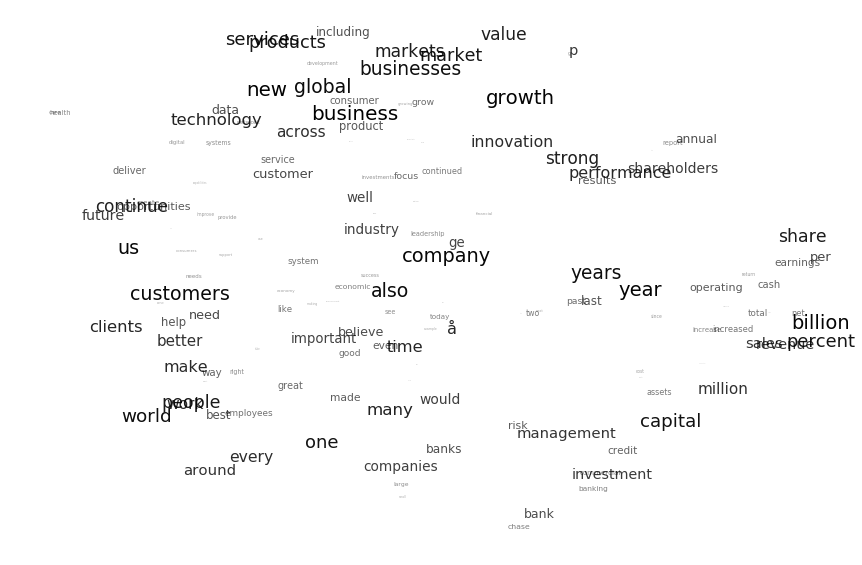

In [23]:
#plot words
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, 
                (tsneWords[:, 0][i],tsneWords[:, 1][i]), 
                size =  20 * (numWords - i) / numWords, 
                alpha = .8 * (numWords - i) / numWords + .2)
plt.xticks(())
plt.yticks(())
plt.show()

I've been reading a lot of these letters and knew that 'financial issues,' 'customers' and 'markets' are three significant topics. However, I've been itnerested in getting at some type of 'social' issue they talk about. Unfortunately, it really doesn't appear in this plotting (except for possibly the continue/future/communities grouping in the upper left. Note: this was considerably closer to customers than I had expected.

# Doc2Vec

Instead of just looking at just how words embed within in the space, we can look at how the different documents relate to each other within the space. First lets load our data--abstracts of most U.S. physics papers from the 1950s.

In [47]:
apsDF = pandas.read_csv('../data/APSabstracts1950s.csv', index_col = 0)
apsDF[:10]

,copyrightYear,doi,abstract
0,1950,10.1103/RevModPhys.22.221,A summarizing account is given of the research...
1,1951,10.1103/RevModPhys.23.147,New tables of coulomb functions are presented ...
2,1951,10.1103/RevModPhys.23.185,Ionization by electron impact in diatomic gase...
3,1951,10.1103/RevModPhys.23.203,It is shown that the conductivity in the ohmic...
4,1951,10.1103/RevModPhys.23.21,The factorization method is an operational pro...
5,1951,10.1103/RevModPhys.23.311,A brief account is given of Dyson's proof of t...
6,1951,10.1103/RevModPhys.23.315,A systematics is given of all transitions for ...
7,1951,10.1103/RevModPhys.23.322,A systematics of the -transitions of even A nu...
8,1951,10.1103/RevModPhys.23.328,The available experiments on the absorption sp...
9,1952,10.1103/RevModPhys.24.108,The classical theory of the dynamics of viscou...


We will load these as documents into Word2Vec, but first we need to normalize and pick some tags

In [48]:
keywords = ['photomagnetoelectric', 'quantum', 'boltzmann', 'proton', 'positron', 'feynman', 'classical', 'relativity']

In [49]:
apsDF['tokenized_words'] = apsDF['abstract'].apply(lambda x: nltk.word_tokenize(x))
apsDF['normalized_words'] = apsDF['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = None))

In [50]:
taggedDocs = []
for index, row in apsDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['copyrightYear'])
    docKeywords.append(row['doi']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
apsDF['TaggedAbstracts'] = taggedDocs

Now we can train a Doc2Vec model:

In [51]:
apsD2V = gensim.models.doc2vec.Doc2Vec(apsDF['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions

We can get vectors for the tags/documents, just as we did with words. Documents are actually the centroids (high dimensional average points) of their words. 

In [52]:
apsD2V.docvecs[1952]

array([ 1.4472057 ,  0.24151105,  1.4529102 , -0.48861116,  0.6868117 ,
       -1.3785752 ,  0.13415655, -0.5344019 ,  0.5693333 , -0.23462686,
        1.1002676 ,  0.39297134, -0.25842857, -0.03982326,  0.8115673 ,
       -1.4172472 , -0.06062064,  0.4072115 ,  0.2101775 , -0.618725  ,
        0.55040103, -0.7575754 ,  0.16589443,  0.7925147 , -1.3540791 ,
       -0.5886038 ,  0.41900942,  1.1769227 , -0.73046726, -0.708622  ,
       -0.63938767, -0.3272466 , -0.5372213 ,  0.87279457,  0.64672405,
       -1.1344701 , -1.3500414 , -0.75985295,  0.44582447, -0.17545997,
       -1.0247983 ,  1.8980108 ,  0.49341756,  0.91781527,  1.2768897 ,
        0.57808405, -0.59792674,  1.2077957 ,  0.4156935 , -1.116661  ,
        0.6752346 , -1.3050923 ,  1.245691  , -1.3361976 , -0.9988653 ,
       -1.030869  ,  0.5122599 ,  0.31949788, -0.6917912 ,  0.6143349 ,
        1.7665985 ,  0.50717974, -1.5136544 , -0.77875733,  0.06046138,
       -0.24858636,  0.6808486 , -1.5022327 ,  0.00380828, -0.10

The words can still be accessed in the same way:

In [53]:
apsD2V['atom']

array([-0.28005564,  0.83915806, -0.20142052,  0.28903246,  0.03734107,
        0.12756924,  0.3365373 ,  0.05776993,  1.0842034 , -0.7220571 ,
        0.78441966,  0.09692722,  0.67182714,  0.1889587 ,  0.18365024,
        0.05593599, -0.41428185,  0.24138959,  1.052728  ,  0.2599958 ,
       -1.1115731 ,  0.39460984, -0.1183181 ,  1.0861142 ,  0.0084199 ,
       -1.1546828 ,  0.55968434, -0.03865654,  0.04534305,  0.33638972,
       -0.0649552 , -0.7070872 , -0.3109811 , -0.5057666 , -0.2826874 ,
        0.11259948, -0.5793757 , -0.16026467,  0.7010555 ,  0.0214746 ,
       -0.6675083 ,  0.4805284 , -0.32963502,  0.35961068, -0.019063  ,
        0.84276617,  0.15217927,  0.53575534, -0.16877607, -0.42177013,
        1.0265858 , -0.6401547 ,  0.97491235, -0.16528952, -0.707953  ,
       -0.44002172,  0.58148366,  0.2095534 , -0.6078042 ,  0.11130964,
        0.46082792,  0.6065794 , -0.2758843 ,  0.20257945, -0.13518263,
       -0.14133808,  0.2200109 ,  0.17797554, -0.2505772 ,  0.54

We can still use the ``most_similar`` command to perform simple semantic equations:

In [54]:
apsD2V.most_similar(positive = ['atom','electrons'], negative = ['electron'], topn = 1)

[('atoms', 0.831512451171875)]

This is interesting. **Electron** is to **electrons** as **atom** is to **atoms**. Another way to understand this, developed below is: **electrons - electron** induces a singular to plural dimension, so when we subtract **electron** from **atom** and add **electrons**, we get **atoms**! 

In [55]:
apsD2V.most_similar(positive = ['einstein','law'], negative = ['equation'], topn = 1)

[('feature', 0.9257014989852905)]

In other words **Einstein** minus **equation** plus **law** equals **Meissner**--Walthur Meissner studied mechanical engineering and physics ... and was more likely to produce a "law" than a "equation", like the Meissner effect, the damping of the magnetic field in superconductors. If we built our word-embedding with a bigger corpus like the entire arXiv, a massive repository of physics preprints, we would see many more such relationships like **gravity - Newton + Einstein = relativity**.

We can also compute all of these *by hand*--explicitly wth vector algebra: 

In [56]:
sklearn.metrics.pairwise.cosine_similarity(apsD2V['electron'].reshape(1,-1), apsD2V['positron'].reshape(1,-1))
#We reorient the vectors with .reshape(1, -1) so that they can be computed without a warning in sklearn

array([[0.5974667]], dtype=float32)

In the doc2vec model, the documents have vectors just as the words do, so that we can compare documents with each other and also with words (similar to how a search engine locates a webpage with a query). First, we will calculate the distance between a word and documents in the dataset:

In [57]:
apsD2V.docvecs.most_similar([ apsD2V['electron'] ], topn=5 )

[('10.1103/PhysRev.104.1444', 0.6126227378845215),
 ('10.1103/PhysRev.100.1646', 0.6077008247375488),
 ('10.1103/PhysRev.109.319', 0.6056624054908752),
 ('10.1103/PhysRev.104.1528', 0.5926605463027954),
 ('10.1103/PhysRev.102.805', 0.5891528129577637)]

If we search for the first of these on the web (these are doi codes), we find the following...a pretty good match:
<img src='../data/PhysRev.98.875.jpg'>

Now let's go the other way around and find words most similar to this document:

In [58]:
apsD2V.most_similar( [ apsD2V.docvecs['10.1103/PhysRev.98.875'] ], topn=5) 

[('longitude', 0.8157679438591003),
 ('running', 0.813378632068634),
 ('diurnal', 0.8026859164237976),
 ('flares', 0.7800118923187256),
 ('intensity', 0.7783427834510803)]

We can even look for documents most like a query composed of multiple words:

In [59]:
apsD2V.docvecs.most_similar([ apsD2V['electron']+apsD2V['positron']+apsD2V['neutron']], topn=5 )

[('10.1103/PhysRev.89.1053', 0.7741438746452332),
 ('10.1103/PhysRev.105.1037', 0.7739917635917664),
 ('10.1103/PhysRev.113.156', 0.7706084251403809),
 ('10.1103/PhysRev.89.724', 0.7684460282325745),
 ('10.1103/PhysRev.101.388', 0.7664670944213867)]

Now let's plot some words and documents against one another with a heatmap:

In [60]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

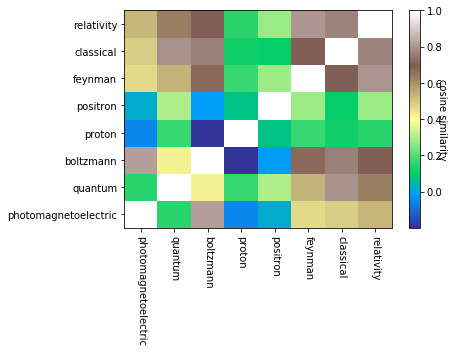

In [61]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

Now let's look at a heatmap of similarities between the first ten documents in the corpus:

In [62]:
targetDocs = apsDF['doi'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

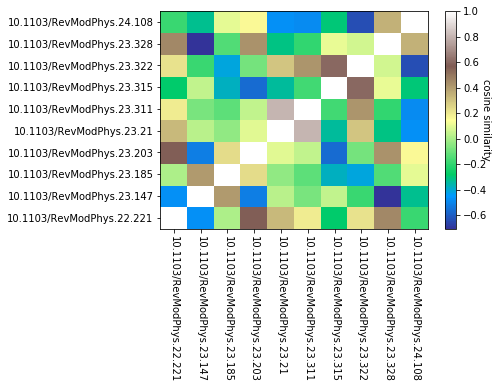

In [63]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

Now let's look at a heatmap of similarities between the first ten documents and our keywords:

In [64]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

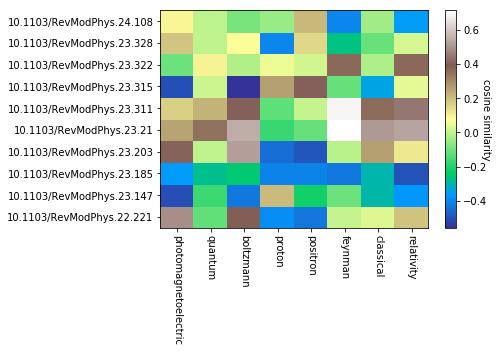

In [65]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

We will save the model in case we would like to use it again.

In [66]:
apsD2V.save('apsW2V')

We can later load it:

In [67]:
#apsD2V = gensim.models.word2vec.Word2Vec.load('data/apsW2V')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that build a doc2vec model with your corpus. Interrogate document and word relationships in the resulting space. Construct a heatmap that plots the distances between a subset of your documents against each other, and against a set of informative words. Find distances between *every* document in your corpus and a word or query of interest. What do these doc-doc proximities reveal about your corpus? What do these word-doc proximities highlight? Demonstrate and document one reasonable way to select a defensible subset of query-relevant documents for subsequent analysis.

In [51]:
# create index of interesting words
keywords = ['communities', 'help', 'employee', 'customer', 'shareholder', 'dividend', 'regulatory', 'market']

In [52]:
#ensure words are normalized 
df['tokenized_words'] = df['text'].apply(lambda x: nltk.word_tokenize(x))
df['normalized_words'] = df['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = None))

In [53]:
taggedDocs = []
for index, row in df.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['year'])
    docKeywords.append(row['company']) #This lets us extract individual documents (by company year)
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
df['TaggedText'] = taggedDocs

In [54]:
#train doc 
lettersD2V = gensim.models.doc2vec.Doc2Vec(df['TaggedText'], size = 100) #Limiting to 100 dimensions

In [55]:
lettersD2V.most_similar(positive = ['communities','education'], negative = ['global'], topn = 1)

[('repeat', 0.9658060669898987)]

In [56]:
lettersD2V.most_similar(positive = ['market','customer'], negative = ['global'], topn = 1)

[('standard', 0.8041067719459534)]

In [57]:
lettersD2V.docvecs.most_similar([ lettersD2V['community']+lettersD2V['environment']+lettersD2V['education']], topn=5 )

[('Citigroup ', 0.9680181741714478),
 ('UnitedHealth Group ', 0.9432245492935181),
 ('2014', 0.9373717308044434),
 ('ExxonMobil Letter ', 0.9227093458175659),
 ('Disney Letter ', 0.8819825649261475)]

In [60]:
lettersD2V.most_similar( [ lettersD2V.docvecs['Disney Letter '] ], topn=5) 

[('contributions', 0.9915191531181335),
 ('story', 0.9891424775123596),
 ('successes', 0.9889246225357056),
 ('apparel', 0.98711097240448),
 ('union', 0.9865443110466003)]

In [73]:
#distance between every letter and the word 'customer'
for index, row in df.iterrows():
    print(row['company'] + 'has distance with "customer" of : ')
    print(sklearn.metrics.pairwise.cosine_similarity(lettersD2V['customer'].reshape(1,-1), lettersD2V.docvecs[row['company']].reshape(1,-1)))


3M Letter has distance with "customer" of : 
[[0.09321653]]
Alcoa Letter has distance with "customer" of : 
[[0.6149768]]
American Express Letter has distance with "customer" of : 
[[-0.48950055]]
AT&T Letter has distance with "customer" of : 
[[-0.00644445]]
Boeing Letter has distance with "customer" of : 
[[-0.06896746]]
Caterpillar Letter has distance with "customer" of : 
[[0.47616044]]
Citigroup Letter has distance with "customer" of : 
[[0.5531465]]
Coca Cola Letter has distance with "customer" of : 
[[-0.75906384]]
Disney 2000 Lehas distance with "customer" of : 
[[0.40719655]]
DuPont Letter has distance with "customer" of : 
[[-0.3988949]]
Eastman Kodak Letter has distance with "customer" of : 
[[0.64103305]]
ExxonMobil Letter has distance with "customer" of : 
[[0.6222638]]
General Electric Letter has distance with "customer" of : 
[[0.3070746]]
Hewlett Packard Letter has distance with "customer" of : 
[[0.53862923]]
Home Depot Letter has distance with "customer" of : 
[[0.809

[[0.45028177]]
General Electric has distance with "customer" of : 
[[0.31559777]]
Goldman Sachs has distance with "customer" of : 
[[-0.3142393]]
Home Depot has distance with "customer" of : 
[[0.7279172]]
IBM has distance with "customer" of : 
[[0.31825528]]
Intel has distance with "customer" of : 
[[0.63175505]]
Johnson and Johnson has distance with "customer" of : 
[[0.00096942]]
JPMorgan Chase has distance with "customer" of : 
[[-0.06441884]]
McDonald's has distance with "customer" of : 
[[0.53919184]]
Microsoft has distance with "customer" of : 
[[0.5572297]]
Nike has distance with "customer" of : 
[[0.65377444]]
P&G has distance with "customer" of : 
[[0.20435478]]
Pfizer has distance with "customer" of : 
[[-0.12014069]]
Travelers has distance with "customer" of : 
[[-0.6429227]]
United Technologies Corporation has distance with "customer" of : 
[[0.49517712]]
Verizon has distance with "customer" of : 
[[0.63742554]]
Walmart has distance with "customer" of : 
[[0.77262044]]
Cis

In [62]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = lettersD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, lettersD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

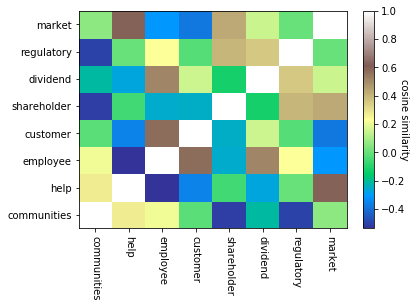

In [63]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

In [66]:
targetDocs = df['company'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = lettersD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec,lettersD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

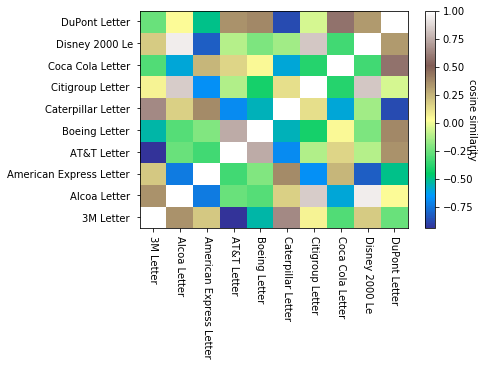

In [67]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

these studies indicate that most letters commonly discuss customers, markets, and dividends, BUT communities, enviornment, education and help is less commonly focused. These could be interesting metrics to explore further.

# Projection

We can also project word vectors to an arbitray semantic dimension. To demonstrate this possibility, let's first load a model trained with New York Times news articles. 

In [68]:
nytimes_model = gensim.models.KeyedVectors.load_word2vec_format('../data/nytimes_cbow.reduced.txt')

First we can visualize with dimension reduction

In [69]:
#words to create dimensions
tnytTargetWords = ['man','him','he', 'woman', 'her', 'she', 'black','blacks','African', 'white', 'whites', 'Caucasian', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive']
#words we will be mapping
tnytTargetWords += ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse", "steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry", "basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(nytimes_model[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.343139, -0.117117, -0.50773 , ..., -0.995696,  0.921299,
         0.943769],
       [-0.362909, -0.263528,  0.032661, ..., -0.043032, -0.178965,
         0.353556],
       [-0.70167 , -0.344525, -0.320714, ...,  0.009001,  0.11055 ,
         0.751077],
       ...,
       [-2.391626, -1.90143 ,  1.031182, ...,  2.947464,  1.01588 ,
         2.00033 ],
       [-2.432387, -1.161415,  1.060064, ...,  4.402381,  0.500471,
         1.644596],
       [ 0.981931,  0.628094, -0.747547, ...,  1.612927,  1.148063,
         1.063776]], dtype=float32)

In [70]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

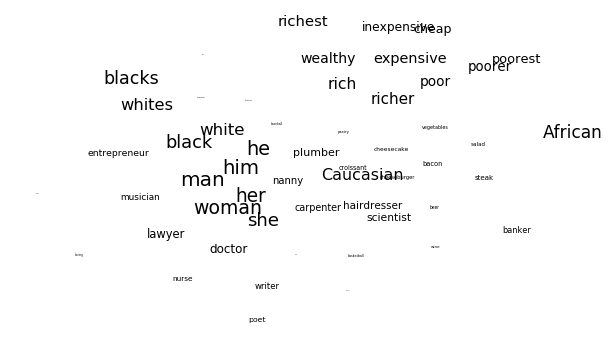

In [71]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  20 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

Define some convenient functions for getting dimensions. 

In [72]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

Let's calculate three dimensions: gender, race, and class.

In [73]:
Gender = dimension(nytimes_model, ['man','him','he'], ['woman', 'her', 'she'])
Race = dimension(nytimes_model, ['black','blacks','African'], ['white', 'whites', 'Caucasian'])
Class = dimension(nytimes_model, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])

Here we have some words.

In [74]:
Occupations = ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse"]

Foods = ["steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry"]

Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

Define a function to project words in a word list to each of the three dimensions.

In [75]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'gender': g, 'race': r, 'class': c}, index = word_list)
    return df

Get the projections.

In [76]:
OCCdf = makeDF(nytimes_model, Occupations) 
Fooddf = makeDF(nytimes_model, Foods)
Sportsdf = makeDF(nytimes_model, Sports)

Define some useful functions for plotting.

In [77]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Plot the occupational words in each of the three dimensions.

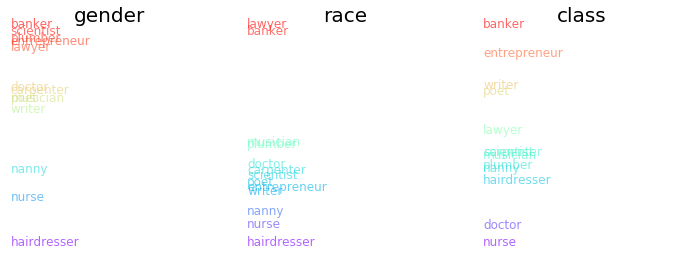

In [78]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'class')
plt.show()

Foods:

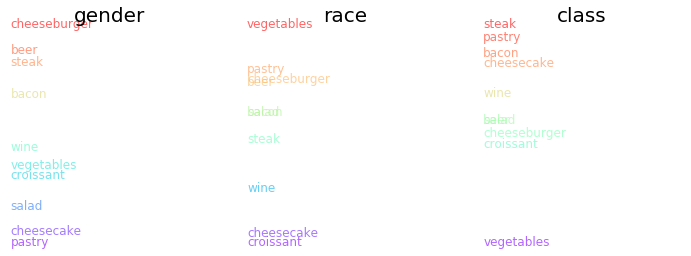

In [79]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Fooddf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Fooddf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Fooddf, 'class')
plt.show()

Sports:

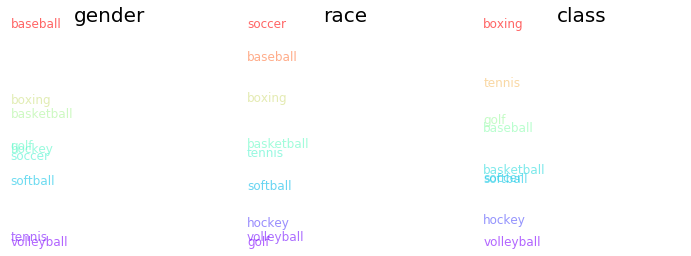

In [80]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Sportsdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Sportsdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Sportsdf, 'class')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that identify semantic dimensions of interest from your data (e.g., gender: man-woman) and project words onto these dimensions. Plot the array of relevant words along each semantic dimension. Which words are most different. Which dimensions are most different? On which dimension are your words most different? Print three short textual examples from the corpus that illustrate the association you have explored.

<span style="color:red">***Stretch***: Project documents from your corpus along a dimension of interest. Sample relevant documents from your corpus with this functionality and explain your rationale? Calculate the cosine of the angle between two dimensions (encoded as vectors) of interest. What does this suggest about the relationship between them within your corpus? 

<span style="color:red">***Stretch***: Create 90% bootstrap confidence intervals around your word projections onto a given dimension. Which words are *significantly* different on your semantic dimension of interest?

In [76]:
#words to create dimensions
TargetWords = ['education','climate','environment', 'performance', 'diversity', 'women', 'man','white','black', 'growth', 'global', 'partnerships', 'deliver', 'dividend', 'government', 'best', 'future', 'poor', 'cash', 'system', 'management', 'value']
#words we will be mapping
TargetWords += ["communities","community","business","market", "company","shareholder","people","customer","customers", "employee","employees","board", "shareholders", "values", "market", "markets", "workers", "worker", "associates", "value", "businesses", "clients", "regulatory", "capital", "investments", "product", "consumer", "consumers", "services", "banks", "bank"]


wordsSubMatrix = []
for word in TargetWords:
    wordsSubMatrix.append(lettersW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[ 0.4775646 ,  0.15524745, -0.1501412 , ..., -0.35718936,
        -0.07046828,  0.32185656],
       [ 0.25720197,  0.03766631, -0.17522086, ..., -0.14620027,
         0.05844387,  0.14966191],
       [ 0.1635307 ,  0.1429659 , -0.31265154, ..., -0.19315231,
         0.06450877,  0.32934335],
       ...,
       [ 1.0744805 , -0.07470151,  0.05853174, ..., -0.6333186 ,
        -0.45619148,  0.45847172],
       [ 0.9384336 , -0.67244977,  0.1428034 , ...,  0.04342303,
         1.001535  ,  0.29381168],
       [ 1.7151235 , -0.77709526,  0.6498856 , ..., -0.28184712,
         1.1531781 ,  0.3298708 ]], dtype=float32)

In [77]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

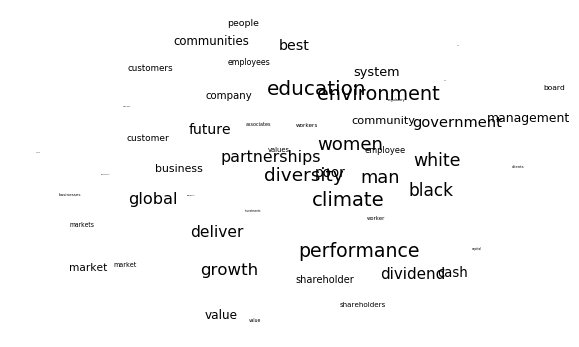

In [78]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(TargetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (len(TargetWords) - i) / len(TargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

In [80]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

In [93]:
#dimensions
Performance = dimension(lettersW2V, ['growth','deliver','dividend','market'], ['customers', 'employees', 'people'])
Community = dimension(lettersW2V, ['education','communities','people','partnerships'], ['business', 'market', 'management'])
Stakeholders = dimension(lettersW2V, ['customer', 'diversity', 'worker', 'government', 'customers'], ['board', 'management', 'business', 'shareholder', 'shareholders'])

In [98]:
#words
value = ["cash","money","dividend","value","future", "growth","values","earnings","share","stock", "company","businesses","plan"]

people = [ "worker", "employee", "management", "education", "development", "improve", "associates", "clients", "client"]

product  = ["deliver", "service", "product", "good", "business", "performance", "technology", "products", "improvements"]

In [99]:
#function projects words onto dimensions
def makeDF(model, word_list):
    p = []
    c = []
    s = []
    for word in word_list:
        p.append(sklearn.metrics.pairwise.cosine_similarity(lettersW2V[word].reshape(1,-1), Performance.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(lettersW2V[word].reshape(1,-1), Community.reshape(1,-1))[0][0])
        s.append(sklearn.metrics.pairwise.cosine_similarity(lettersW2V[word].reshape(1,-1), Stakeholders.reshape(1,-1))[0][0])
    dfr = pandas.DataFrame({'performance': p, 'community': c, 'stakeholders': s}, index = word_list)
    return dfr

In [100]:
#projections
valuedf = makeDF(lettersW2V, value) 
peopledf = makeDF(lettersW2V, people)
productdf = makeDF(lettersW2V, product)

In [101]:
#plotting functions
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

value 

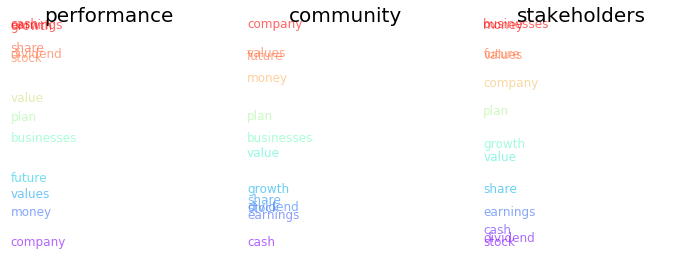

In [102]:
#plot value words
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, valuedf, 'performance')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, valuedf, 'community')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, valuedf, 'stakeholders')
plt.show()

people:

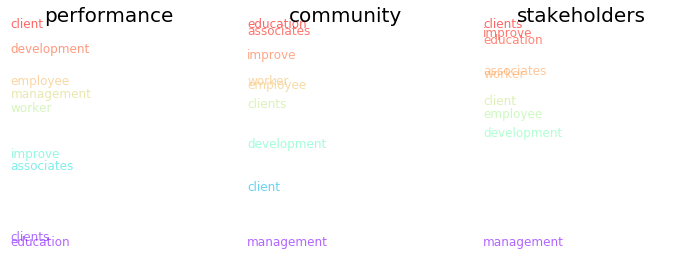

In [103]:
#plot value words
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, peopledf, 'performance')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, peopledf, 'community')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, peopledf, 'stakeholders')
plt.show()

product:

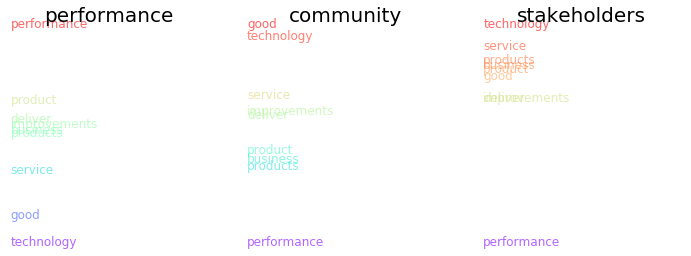

In [104]:
#plot value words
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, productdf, 'performance')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, productdf, 'community')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, productdf, 'stakeholders')
plt.show()

Creating the dimensions is a difficult study. I Find the 'value' words to be most interesting when projected on the performance and community dimensions.

In [105]:
print(df['text'][4][:2000])

here is our plan for growing the boeing company.it covers
three periods of time:near, medium and long term.the prime

objective is to create converging and ever-increasing streams

of value Ã for customers and shareholders.
running healthy core businesses 
over the next three to five years, we have an extraordi-
nary opportunity to increase operating margins.we can 

reach this goal by empowering boeing people to achieve 

substantial results.
boeing has long been known for its many superb engineers,
technicians and scientists.our leadership center in st.louis

is multiplying their value by adding business skills to their

extraordinary technical skills.we are turning managers into

business leaders.over the past two years, we have put 
5,000managers through intensive courses to hone their business

and leadership skills.every graduate of the center becomes a

teacher to others.
we are also putting systems into place to drive detailed finan-
cial awareness and discipline deep into the

The above text illustrates how people can be close together, such as customers and shareholders. Meanwhile employees and education are close together because htey are attempting to teach them new skills.

In [106]:
print(df['text'][2][:2000])

cardmembers, a reflection of our successful efforts to deepen relationships with
clients. global trading continued to grow its business with financial institutions and pri-
vate banking clients and expanded its capabilities to meet the needs of other ameri-

can express units and clients.
throughout the year, we continued to integrate the bankÃs activities with those of
other american express units. we stepped up marketing of our private bankÃs ser-

vices to a highly targeted group of cardmembers outside the united states, while

the companyÃs international card business made platinum cards
Â¨available to qual-ified aeb clients. in addition, we continued to see increased sales of our american

express funds and the american express offshore alternative investment fund,

both of which have portfolios managed by american express financial advisors.

we also market aefainvestment certificates, and operate a joint venture with aefa

to market deposit products. 
these efforts were helpe

The above text illustrates how 'clients' is similar to customers, business, and performance.

In [107]:
print(df['text'][82][:2000])

The Most Admired Telecommunications Company
Verizon is committed to putting our customers first by providing excellent 
service and great communications experiences. Weâ¢re also a responsible 

corporate citizen, using our broadband and wireless networks to help 

make lives better. Our hard work and dedication are paying off Å in the 

most recent rankings of the ï¬Worldâ¢s Most Admired Companiesï¬ by 
Fortune

magazine, Verizon was named #1 in the global telecommunications sector, 

according to our peers. Our goal is to tap the potential of our employees 

and our networks to address social issues that are critical to the well-being 

of the communities we serve.
Network Innovation
Verizonâ¢s intelligent broadband networks are powerful engines of growth 

and innovation that will continue to have a positive impact on many of 

the issues facing our society. As broadband becomes deeply embedded 

in the lives of our customers, more Americans will have access to quality 

educat

The above shows that employees and community are both ranked highly on the people dimension